<a href="https://colab.research.google.com/github/jydiw/nyt-covid-19-data/blob/master/eda_nytimes-data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Combining NYTimes data with county census and geoson data

In [1]:
import numpy as np
import numpy.polynomial.polynomial as poly      # linear regression
import pandas as pd

from scipy.signal import savgol_filter          # fast smoothing of data

# opening external coordinates
import json

# opening urls
from urllib.request import urlopen

# benchmarking
from time import time

# date/time operations
from datetime import datetime, timedelta
from pytz import timezone

import json

# plotting
import matplotlib.pyplot as plt

# import nytimes data

New York Times data has a few caveats, including treating New York City, Kansas City, and Joplin as single entities rather than including them in their respective counties. Read their [README](https://github.com/nytimes/covid-19-data/blob/master/README.md) for more information.

In [2]:
def optimize(df):
    '''
    Optimizes the data types in a pandas dataframe.
    '''
    dft = df.copy()
    # converts to datetime if possible
    dft = dft.apply(lambda col:
        pd.to_datetime(col, errors='ignore') if col.dtypes=='object' else col)
    
    # if there are less than half as many unique values as there are rows, convert to category
    for col in dft.select_dtypes(include='object'):
        if len(dft[col].unique()) / len(df[col]) < 0.5:
            dft[col] = dft[col].astype('category')
            
    # downcasts numeric columns if possible
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='integer') if col.dtypes=='int64' else col)
    dft = dft.apply(lambda col: 
        pd.to_numeric(col, downcast='float') if col.dtypes=='float64' else col)
    
    return dft

In [20]:
with urlopen('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv') as response:
    nyt_df_raw = optimize(pd.read_csv(response, dtype={'fips':'str'}))
nyt_df_raw.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0


In [21]:
nyt_df_raw['fips'] = nyt_df_raw['fips'].astype('object')
nyt_df_raw.loc[nyt_df_raw['county'] == 'New York City','fips'] = '36NYC'
nyt_df_raw.loc[nyt_df_raw['county'] == 'Kansas City','fips'] = '29KCM'
nyt_df_raw.loc[nyt_df_raw['county'] == 'Joplin','fips'] = '29JOP'
nyt_df_raw['fips'] = nyt_df_raw['fips'].astype('category')

In [22]:
nyt_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424607 entries, 0 to 424606
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    424607 non-null  datetime64[ns]
 1   county  424607 non-null  category      
 2   state   424607 non-null  category      
 3   fips    420743 non-null  category      
 4   cases   424607 non-null  int32         
 5   deaths  424607 non-null  int16         
dtypes: category(3), datetime64[ns](1), int16(1), int32(1)
memory usage: 8.0 MB


# import census and GeoJSON data

In [5]:
with open('../data/processed/geo_json.json') as f:
    geo_json = json.load(f)

In [23]:
dem_df_to_merge = optimize(pd.read_csv('../data/processed/dem_df_to_merge.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(dem_df_to_merge.shape)
dem_df_to_merge.head()

(3140, 40)


,state,county,state_fips,fips,total_pop,white,black,asian,hispanic,area_land,...,pop_density,per_white,per_black,per_asian,per_hispanic,per_total_votes,education,per_gop,mask,cluster
0,Alabama,Autauga,1,01001,55869,41215,11098,646,1671,1539.602173,...,36.287949,0.737708,0.198643,0.011563,0.029909,0.441408,3.174487,0.754018,3.003,0
1,Alabama,Baldwin,1,01003,223234,185747,19215,2346,10534,4117.546875,...,54.215294,0.832073,0.086076,0.010509,0.047188,0.421486,3.329113,0.798123,2.968,4
2,Alabama,Barbour,1,01005,24686,11235,11807,116,1117,2292.144775,...,10.769826,0.455116,0.478287,0.004699,0.045248,0.420886,2.380620,0.528359,2.928,1
3,Alabama,Bibb,1,01007,22394,16663,4719,46,623,1612.167480,...,13.890616,0.744083,0.210726,0.002054,0.027820,0.390640,2.459823,0.782270,3.348,0
4,Alabama,Blount,1,01009,57826,50176,872,163,5582,1670.103882,...,34.624191,0.867707,0.015080,0.002819,0.096531,0.438972,2.606581,0.913855,2.892,3


## engineer per capita columns

In [24]:
nyt_df = nyt_df_raw.merge(
    dem_df_to_merge[['fips', 'total_pop']], 
    on='fips', 
    suffixes=('_x','')
)

# df_all = df_all.drop(['county_x', 'state_x'], axis=1)
nyt_df[['cases_per_100k', 'deaths_per_100k']] = nyt_df[['cases', 'deaths']].div(nyt_df['total_pop'], axis=0) * 100_000
nyt_df = nyt_df.drop(columns=['total_pop'])
nyt_df = nyt_df.sort_values(by=['date', 'fips'])

print(nyt_df.shape)
nyt_df.head()

(412471, 8)


,date,county,state,fips,cases,deaths,cases_per_100k,deaths_per_100k
0,2020-01-21,Snohomish,Washington,53061,1,0,0.121642,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0,0.121642,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0,0.121642,0.0
204,2020-01-24,Cook,Illinois,17031,1,0,0.019417,0.0
3,2020-01-24,Snohomish,Washington,53061,1,0,0.121642,0.0


## engineer change columns and smooth

In [25]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=False):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7, clip=False):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    if clip:
        df[cols_d] = df[cols_d].clip(lower=0)
    return (df, cols_d)

nyt_df, new_cols = add_change_cols(nyt_df, cols, pre='new_', clip=True)
nyt_df, new_cols_7sg = add_savgol_cols(nyt_df, new_cols, clip=True)
nyt_df, new_cols_15sg = add_savgol_cols(nyt_df, new_cols, window=15, clip=True)
nyt_df, delta_new_cols = add_change_cols(nyt_df, new_cols, pre='delta_')
nyt_df, delta_new_cols_7sg = add_savgol_cols(nyt_df, delta_new_cols)
nyt_df, delta_new_cols_15sg = add_savgol_cols(nyt_df, delta_new_cols, window=15)

print(nyt_df.columns)
nyt_df.head()

Index(['date', 'county', 'state', 'fips', 'cases', 'deaths', 'cases_per_100k',
       'deaths_per_100k', 'new_cases', 'new_deaths', 'new_cases_per_100k',
       'new_deaths_per_100k', 'new_cases_7sg', 'new_deaths_7sg',
       'new_cases_per_100k_7sg', 'new_deaths_per_100k_7sg', 'new_cases_15sg',
       'new_deaths_15sg', 'new_cases_per_100k_15sg',
       'new_deaths_per_100k_15sg', 'delta_new_cases', 'delta_new_deaths',
       'delta_new_cases_per_100k', 'delta_new_deaths_per_100k',
       'delta_new_cases_7sg', 'delta_new_deaths_7sg',
       'delta_new_cases_per_100k_7sg', 'delta_new_deaths_per_100k_7sg',
       'delta_new_cases_15sg', 'delta_new_deaths_15sg',
       'delta_new_cases_per_100k_15sg', 'delta_new_deaths_per_100k_15sg'],
      dtype='object')


,date,county,state,fips,cases,deaths,cases_per_100k,deaths_per_100k,new_cases,new_deaths,...,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg,delta_new_cases_15sg,delta_new_deaths_15sg,delta_new_cases_per_100k_15sg,delta_new_deaths_per_100k_15sg
0,2020-01-21,Snohomish,Washington,53061,1,0,0.121642,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
1,2020-01-22,Snohomish,Washington,53061,1,0,0.121642,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
2,2020-01-23,Snohomish,Washington,53061,1,0,0.121642,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
204,2020-01-24,Cook,Illinois,17031,1,0,0.019417,0.0,0.0,0.0,...,0.0,0.0,-0.178571,0.0,-0.003467,0.0,0.025,0.0,0.000485,0.0
3,2020-01-24,Snohomish,Washington,53061,1,0,0.121642,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0


In [26]:
nyt_df['days'] = ((nyt_df['date'] - nyt_df['date'].min()) / np.timedelta64(1, 'D')).astype('int')
nyt_df['mortality_rate'] = nyt_df['deaths'] / nyt_df['cases']
nyt_df.to_csv('../data/nyt_df.csv', index=False)

In [ ]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [5]:
with open('../data/processed/geo_json_ac.json') as f:
    geo_json_ac = json.load(f)

In [6]:
dem_df_ac = optimize(pd.read_csv('../data/processed/dem_df_ac.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(dem_df_ac.shape)
dem_df_ac.head()

(518, 40)


,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area_land,...,per_white,per_black,per_asian,per_hispanic,per_total_votes,per_votes_gop,per_votes_dem,education,mask,per_gop
0,Alabama,0,Autauga-Bibb-Chambers-Cherokee-Chilton-Clay-Cl...,1282042,01001-01007-01017-01019-01021-01027-01029-0103...,948951,242950,15387,48412,44122.914062,...,0.740187,0.189502,0.012002,0.037762,0.418653,0.711412,0.265271,2.862554,2.931403,0.728396
1,Alabama,1,Barbour-Bullock-Butler-Choctaw-Clarke-Conecuh-...,419390,01005-01011-01013-01023-01025-01035-01041-0104...,186960,208094,2891,11332,44918.742188,...,0.445790,0.496183,0.006893,0.027020,0.473404,0.465672,0.523106,2.615394,2.979478,0.470957
2,Alabama,2,Montgomery,226486,01101,74059,133283,7353,8344,2033.918457,...,0.326992,0.588482,0.032466,0.036841,0.417562,0.358753,0.620363,3.253709,3.029000,0.366405
3,Alabama,3,Blount-Calhoun-DeKalb-Etowah-Jackson-Limestone...,1019420,01009-01015-01049-01055-01071-01083-01095-0110...,800521,111621,11081,72491,17516.697266,...,0.785271,0.109495,0.010870,0.071110,0.416517,0.767825,0.204868,2.962179,2.972209,0.789381
4,Alabama,4,Baldwin-Mobile,636444,01003-01097,419294,167703,10840,22977,7301.599609,...,0.658807,0.263500,0.017032,0.036102,0.404556,0.636434,0.337265,3.096534,3.008253,0.653625


In [7]:
dem_df_ac.sort_values(by='total_pop').iloc[[0, -1]]

,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area_land,...,per_white,per_black,per_asian,per_hispanic,per_total_votes,per_votes_gop,per_votes_dem,education,mask,per_gop
150,Hawaii,2,Kalawao,86,15005,23,0,7,1,31.057604,...,0.267442,0.000000,0.081395,0.011628,0.005814,1.000000,1.000000,3.144928,3.717,0.500000
61,California,35,Los Angeles,10039107,06037,2615947,798279,1485197,4881970,10510.671875,...,0.260576,0.079517,0.147941,0.486295,0.264174,0.233887,0.714072,3.057121,3.648,0.246727


In [8]:
dem_df_ac.sort_values(by='pop_density').iloc[[0, -1]]

,state,cluster,county,total_pop,fips,white,black,asian,hispanic,area_land,...,per_white,per_black,per_asian,per_hispanic,per_total_votes,per_votes_gop,per_votes_dem,education,mask,per_gop
469,Texas,41,Loving,169,48301,137,6,2,23,1732.230103,...,0.810651,0.035503,0.011834,0.136095,0.378698,0.890625,0.062500,2.533333,3.044000,0.934426
322,New York,16,New York City,8336817,36NYC,2681976,1825848,1228598,2423590,777.950012,...,0.321703,0.219010,0.147370,0.290709,0.298765,0.185155,0.790894,3.265549,3.559508,0.189698


There are several things to consider:

- Raw numbers will show New York City and Los Angeles County with the highest numbers, all other factors being equal.
- Reporting cases as a percentage (or as we'll use later, a per 100k) would better reflect the severity of infections.
- However, a higher population density would likely make it easier to transmit the disease to another person. Looking at the day-to-day change in new cases could allow us to see how quickly the disease is spreading.

The NYTimes dataset deals with New York City, Kansas City, and Joplin as their own entities. As such, they do not have valid `fips` codes; we must add our custom `fips` from our earlier census EDA.

In [9]:
nyt_df['fips'] = nyt_df['fips'].astype('object')
nyt_df.loc[nyt_df['county'] == 'New York City','fips'] = '36NYC'
nyt_df.loc[nyt_df['county'] == 'Kansas City','fips'] = '29KCM'
nyt_df.loc[nyt_df['county'] == 'Joplin','fips'] = '29JOP'
nyt_df['fips'] = nyt_df['fips'].astype('category')

In [10]:
nyt_df[nyt_df['fips']=='36NYC']

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,36NYC,1,0
448,2020-03-02,New York City,New York,36NYC,1,0
482,2020-03-03,New York City,New York,36NYC,2,0
518,2020-03-04,New York City,New York,36NYC,2,0
565,2020-03-05,New York City,New York,36NYC,4,0
...,...,...,...,...,...,...
410361,2020-08-07,New York City,New York,36NYC,231942,23567
413582,2020-08-08,New York City,New York,36NYC,232271,23575
416803,2020-08-09,New York City,New York,36NYC,232517,23580
420023,2020-08-10,New York City,New York,36NYC,232756,23586


# merge `nyt_df` and `pop_df` for feature engineering

In [12]:
dem_df_to_merge = optimize(pd.read_csv('../data/processed/dem_df_to_merge.csv', 
                                 dtype={'fips':'str', 'cluster':'int'}))
print(dem_df_to_merge.shape)
dem_df_to_merge.head()

(3140, 40)


,state,county,state_fips,fips,total_pop,white,black,asian,hispanic,area_land,...,pop_density,per_white,per_black,per_asian,per_hispanic,per_total_votes,education,per_gop,mask,cluster
0,Alabama,Autauga,1,01001,55869,41215,11098,646,1671,1539.602173,...,36.287949,0.737708,0.198643,0.011563,0.029909,0.441408,3.174487,0.754018,3.003,0
1,Alabama,Baldwin,1,01003,223234,185747,19215,2346,10534,4117.546875,...,54.215294,0.832073,0.086076,0.010509,0.047188,0.421486,3.329113,0.798123,2.968,4
2,Alabama,Barbour,1,01005,24686,11235,11807,116,1117,2292.144775,...,10.769826,0.455116,0.478287,0.004699,0.045248,0.420886,2.380620,0.528359,2.928,1
3,Alabama,Bibb,1,01007,22394,16663,4719,46,623,1612.167480,...,13.890616,0.744083,0.210726,0.002054,0.027820,0.390640,2.459823,0.782270,3.348,0
4,Alabama,Blount,1,01009,57826,50176,872,163,5582,1670.103882,...,34.624191,0.867707,0.015080,0.002819,0.096531,0.438972,2.606581,0.913855,2.892,3


To reduce the size of the resulting `csv`, we will only merge with the `tot_pop` column to engineer our per capita columns. We can merge with `pop_df` again when plotting our data.

In [13]:
df = nyt_df.merge(
    dem_df_to_merge[['fips', 'cluster', 'state', 'county']], 
    on='fips', 
    suffixes=('_x','')
)

df = df.drop(['county_x', 'state_x'], axis=1)
df = df.sort_values(by=['date', 'fips'])
print(df.shape)
df.head()

(412474, 7)


,date,fips,cases,deaths,cluster,state,county
0,2020-01-21,53061,1,0,10,Washington,Snohomish
1,2020-01-22,53061,1,0,10,Washington,Snohomish
2,2020-01-23,53061,1,0,10,Washington,Snohomish
204,2020-01-24,17031,1,0,11,Illinois,Cook
3,2020-01-24,53061,1,0,10,Washington,Snohomish


In [14]:
df_clustered = df.groupby(by=['state', 'cluster', 'date']).agg(
    cases=('cases', sum),
    deaths=('deaths', sum)
).dropna().reset_index().astype({'cases': 'int', 'deaths':'int'})

df_clustered.head()

,state,cluster,date,cases,deaths
0,Alabama,0,2020-03-13,2,0
1,Alabama,0,2020-03-14,3,0
2,Alabama,0,2020-03-15,5,0
3,Alabama,0,2020-03-16,5,0
4,Alabama,0,2020-03-17,8,0


In [15]:
df = df_clustered.merge(dem_df_ac, on=['state', 'cluster'], suffixes=('_x',''))
df[['cases_per_100k', 'deaths_per_100k']] = df[['cases', 'deaths']].div(df['total_pop'], axis=0) * 100_000
df = df.sort_values(by=['date', 'fips'])

print(df.shape)
df.head()

(76896, 45)


,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,per_asian,per_hispanic,per_total_votes,per_votes_gop,per_votes_dem,education,mask,per_gop,cases_per_100k,deaths_per_100k
74255,Washington,10,2020-01-21,1,0,Snohomish,822083,53061,559806,28841,...,0.118324,0.106032,0.376478,0.376202,0.542634,3.422284,3.583,0.409433,0.121642,0.0
74256,Washington,10,2020-01-22,1,0,Snohomish,822083,53061,559806,28841,...,0.118324,0.106032,0.376478,0.376202,0.542634,3.422284,3.583,0.409433,0.121642,0.0
74257,Washington,10,2020-01-23,1,0,Snohomish,822083,53061,559806,28841,...,0.118324,0.106032,0.376478,0.376202,0.542634,3.422284,3.583,0.409433,0.121642,0.0
24498,Illinois,11,2020-01-24,1,0,Cook,5150233,17031,2162156,1184247,...,0.077317,0.256160,0.399053,0.214193,0.743758,3.411196,3.539,0.223595,0.019417,0.0
74258,Washington,10,2020-01-24,1,0,Snohomish,822083,53061,559806,28841,...,0.118324,0.106032,0.376478,0.376202,0.542634,3.422284,3.583,0.409433,0.121642,0.0


In [17]:
cols = ['cases', 'deaths', 'cases_per_100k', 'deaths_per_100k']

def add_change_cols(df, cols, pre='new_', clip=False):
    df = df.sort_values(by=['date', 'fips'])
    new_cols = [pre + c for c in cols]
    df[new_cols] = df[cols] - df.groupby(by='fips')[cols].shift()
    df[new_cols] = df[new_cols].fillna(0)
    if clip:
        df[new_cols] = df[new_cols].clip(lower=0)
    return (df, new_cols)

def add_savgol_cols(df, cols, window=7, clip=False):
    def my_savgol(x, w):
        if len(x) >= w:
            return savgol_filter(x, w, 1)
        else:
            new_window = int(np.ceil(len(x) / 2) * 2 - 1)
            if new_window <= 1:
                return x
            else:
                return savgol_filter(x, new_window, 1)
    df = df.sort_values(by=['date', 'fips'])
    cols_d = [c + '_' + str(window) + 'sg' for c in cols]
    df[cols_d] = df.groupby(by='fips')[cols].transform(lambda x: my_savgol(x, window))
    if clip:
        df[cols_d] = df[cols_d].clip(lower=0)
    return (df, cols_d)

df, new_cols = add_change_cols(df, cols, pre='new_', clip=True)
df, new_cols_7sg = add_savgol_cols(df, new_cols, clip=True)
df, new_cols_15sg = add_savgol_cols(df, new_cols, window=15, clip=True)
df, delta_new_cols = add_change_cols(df, new_cols, pre='delta_')
df, delta_new_cols_7sg = add_savgol_cols(df, delta_new_cols)
df, delta_new_cols_15sg = add_savgol_cols(df, delta_new_cols, window=15)

print(df.columns)
df.head()

Index(['state', 'cluster', 'date', 'cases', 'deaths', 'county', 'total_pop',
       'fips', 'white', 'black', 'asian', 'hispanic', 'area_land', 'lon',
       'lat', 'votes_gop', 'votes_dem', 'total_votes', 'median_income',
       'pop25', 'no_hs', 'some_hs', 'hs', 'some_college', 'associates',
       'bachelors', 'graduate', 'never', 'rarely', 'sometimes', 'frequently',
       'always', 'pop_density', 'per_white', 'per_black', 'per_asian',
       'per_hispanic', 'per_total_votes', 'per_votes_gop', 'per_votes_dem',
       'education', 'mask', 'per_gop', 'cases_per_100k', 'deaths_per_100k',
       'new_cases', 'new_deaths', 'new_cases_per_100k', 'new_deaths_per_100k',
       'new_cases_7sg', 'new_deaths_7sg', 'new_cases_per_100k_7sg',
       'new_deaths_per_100k_7sg', 'new_cases_15sg', 'new_deaths_15sg',
       'new_cases_per_100k_15sg', 'new_deaths_per_100k_15sg',
       'delta_new_cases', 'delta_new_deaths', 'delta_new_cases_per_100k',
       'delta_new_deaths_per_100k', 'delta_new_cas

,state,cluster,date,cases,deaths,county,total_pop,fips,white,black,...,delta_new_cases_per_100k,delta_new_deaths_per_100k,delta_new_cases_7sg,delta_new_deaths_7sg,delta_new_cases_per_100k_7sg,delta_new_deaths_per_100k_7sg,delta_new_cases_15sg,delta_new_deaths_15sg,delta_new_cases_per_100k_15sg,delta_new_deaths_per_100k_15sg
74255,Washington,10,2020-01-21,1,0,Snohomish,822083,53061,559806,28841,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
74256,Washington,10,2020-01-22,1,0,Snohomish,822083,53061,559806,28841,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
74257,Washington,10,2020-01-23,1,0,Snohomish,822083,53061,559806,28841,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0
24498,Illinois,11,2020-01-24,1,0,Cook,5150233,17031,2162156,1184247,...,0.0,0.0,-0.178571,0.0,-0.003467,0.0,0.025,0.0,0.000485,0.0
74258,Washington,10,2020-01-24,1,0,Snohomish,822083,53061,559806,28841,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0


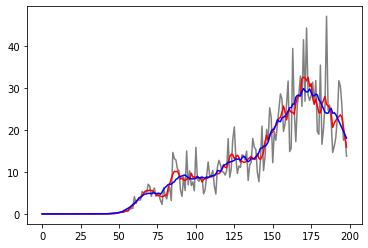

In [19]:
county = 'Los Angeles'
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k', data=df[df['county'] == county], color='gray')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_7sg', data=df[df['county'] == county], color='red')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_15sg', data=df[df['county'] == county], color='blue')

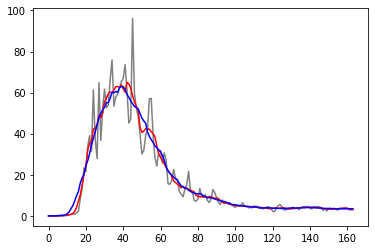

In [20]:
county = 'New York City'
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k', data=df[df['county'] == county], color='gray')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_7sg', data=df[df['county'] == county], color='red')
plt.plot(np.arange(len(df[df['county'] == county])), 'new_cases_per_100k_15sg', data=df[df['county'] == county], color='blue')